In [97]:
import pandas as pd
import numpy as np
from GTC_function import *
import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline

In [135]:
GT1920 = Graph_GT(year = 1868)

In [136]:
#GT1920.country_list()

In [137]:
gra = GT1920.graph()

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [138]:
#nx.spectral_layout(gra,dim =10)

In [139]:
class_index = spectral_clustering(dim_spec = 2, n_cluster = 14, graph = gra)

In [140]:
for k in range(14):
    print(len([gra.nodes()[i] for i in range(len(class_index)) if class_index[i] == k]))

6
7
46
36
37
37
1
20
36
4
2
18
13
5


In [141]:
[gra.nodes()[i] for i in range(len(class_index)) if class_index[i] == 12]

['Sumatra',
 'Montserrat',
 'Hamburg',
 'Scotland',
 'Canary Is. & Cape Colony',
 'British America (Pacific)',
 'Austria-Hungary & Italy',
 'Channel Is.',
 'Algeria',
 'Gambia',
 'Belize (British Honduras)',
 'Newfoundland & Prince Edward Is.',
 'Surinam']

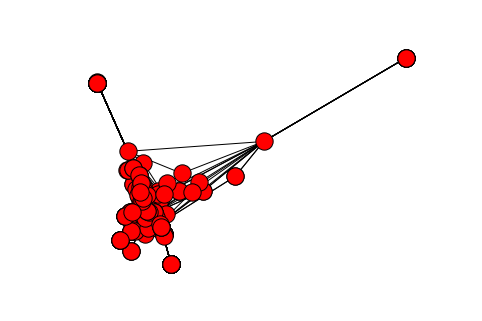

In [142]:
nx.draw_spectral(gra)